# The Stanford Question Answering Dataset

Consists of a Question-Answering Dataset, and a reference text is provided to each of the topics to also feed into the training process.

Example: https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Nikola_Tesla.html

For each question, there are ground truth answers, which are passages from the reference text and the model prediction.

## Bert Structure

Bert has 24 layers and an embedding size of `1024` for a total of 340 million parameters! This all together results in a size of 1,34GB.

The final embedding will be multiplied by the start weight factor of the input and a soft-max function $\frac{e^x}{\sum e^x}$ is applied on this output. This process is also applied of the end weight factor.


In [1]:
!pip install transformers

## Import PyTorch

In [1]:
import torch
from bert_utils import BertUtils

In [3]:
from transformers import BertForQuestionAnswering

pretrained_model_name: str = 'bert-large-uncased-whole-word-masking-finetuned-squad'

model = BertForQuestionAnswering.from_pretrained(pretrained_model_name)

Downloading: 100%|██████████| 443/443 [00:00<00:00, 90.3kB/s]
Downloading: 100%|██████████| 1.25G/1.25G [26:26<00:00, 845kB/s]    


In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 8.30kB/s]
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 304kB/s]  
Downloading: 100%|██████████| 455k/455k [00:01<00:00, 385kB/s]  


In [ ]:
bert_utils = BertUtils(model, tokenizer)

## Ask a Question

A Question-Answer sample consists of a question and a text passage containing the answer to that question.

In the following example, the answer should be 340M.

In [6]:
question: str = "How many parameters does BERT-large have?"
answer_text: str = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

BERT tokenizer has to be run against both the `question` and the `answer_text`.
These variables are first concatenated with a `[SEP]` token as delimiter between them and then fed into BERT.

In [7]:
# Apply the tokenizer to the input text, threating them as a text-pair
input_ids = tokenizer.encode(question, answer_text)

print(f'The input has a total of {len(input_ids)} tokens.')

The input has a total of 70 tokens.


In [8]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, id in zip(tokens, input_ids):

    if id == tokenizer.sep_token_id:
        print('')

    print(f'{token:<12} {id:>6,}')

    if id == tokenizer.sep_token_id:
        print('')

[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029

[SEP]           102

bert         14,324
-             1,011
large         2,312
is            2,003
really        2,428
big           2,502
.             1,012
.             1,012
.             1,012
it            2,009
has           2,038
24            2,484
-             1,011
layers        9,014
and           1,998
an            2,019
em            7,861
##bed         8,270
##ding        4,667
size          2,946
of            1,997
1             1,015
,             1,010
02            6,185
##4           2,549
,             1,010
for           2,005
a             1,037
total         2,561
of            1,997
340          16,029
##m           2,213
parameters   11,709
!               999
altogether   10,462
it            2,009
is            2,003
1             1,015
.             1,01

In [9]:
# Search the input_ids for the first instance of the `[SEP]` token
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token itself
num_seq_a = sep_index + 1

# the remainder are segment B
num_seq_b = len(input_ids) - num_seq_a

# Construct the list of 0s and 1s
segment_ids = [0] * num_seq_a + [1] * num_seq_b

# There should be a segment_id for every input token
assert len(segment_ids) == len(input_ids)

In [15]:
outputs = model(torch.tensor([input_ids]), # the tokens representing our input text
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True)

start_scores = outputs.start_logits
end_scores = outputs.end_logits

### Highlight the answer by looking at the most probable start and end words


In [18]:
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

answer = ' '.join(tokens[answer_start:answer_end+1])

print(f'Answer: <{answer}>')

Answer: <340 ##m>


In [ ]:
answer = bert_utils.get_answer_to_question(question, answer_text)

In [20]:
# Start with the first token
answer = tokens[answer_start]

# Select remaining answer tokens and join them with whitespace
for idx in range(answer_start + 1, answer_end + 1):

    # If it's a subword token, then recombine it with the previous token
    if tokens[idx][0:2] == '##':
        answer += tokens[idx][2:]

    # Otherwise add a space then the token
    else:
        answer += f' {tokens[idx]}' 

print(f"Answer: '{answer}'")

Answer: '340m'


### Visualizing Scores

Generate bar plots that show the start and end scores for every word in the input.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
plt.rcParams['figure.figsize'] = (16, 8)

### Retrieving the start and end scores, use tokens as x-axis labels.

In [23]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# Use the tokens as the x-axis labels. In order to do that, they all need 
# to be unique, so the token index gets added to the end of each one
token_labels = []
for (idx, token) in enumerate(tokens):
    token_labels.append(f'{token:} - {idx:>2}')

#### Create a bar plot showing the score for every input word being the 'start' work

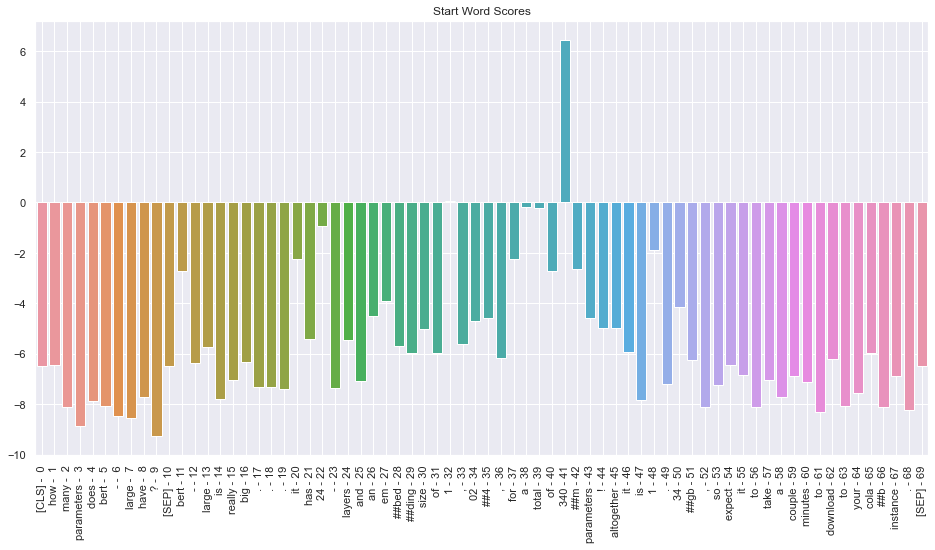

In [25]:
# Create a barplot showing the start word score for all of the tokens
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

# Turn on the vertical grid to help align words to scores
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

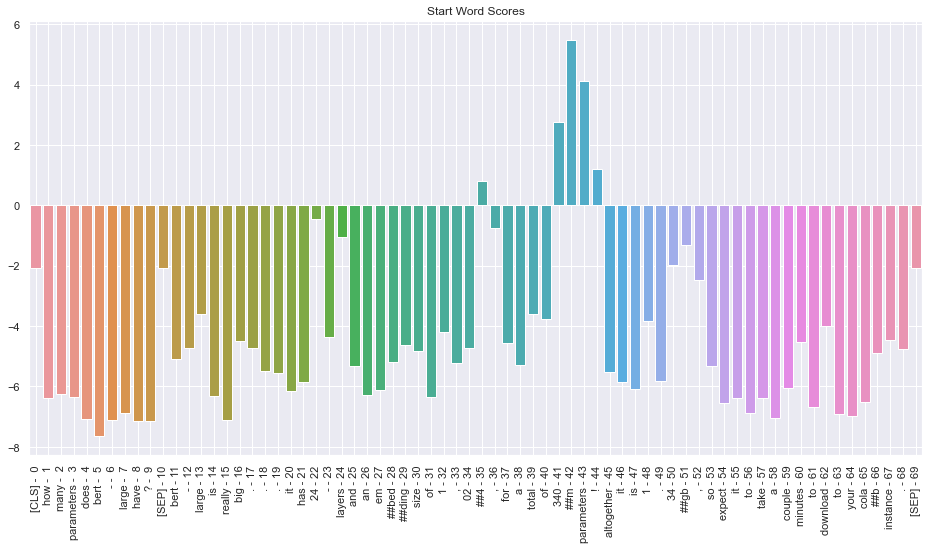

In [26]:
# Create a barplot showing the start word score for all of the tokens
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

# Turn on the vertical grid to help align words to scores
ax.grid(True)

plt.title('Start Word Scores')

plt.show()